# Measuring Communication Efficiency and Learnability of Colors using an Information Bottleneck Framework

In [1]:
import pandas as pd
import numpy as np
from ibhelpers import *

In [2]:
# load the data from the World Color Survey
df = pd.read_csv("wcs/term.txt", delimiter="\t", header=None)
df.columns = ["language", "speaker", "chip", "word"]

## Calculate prior probabilities

For each language, $l$, we can use a frequentist approach (counts) to calculate the observed quantities of $p(w|c,l)$ and $p(c|w,l)$

In [3]:
per_chip_count_df = df.groupby(["language", "chip", "word"]).speaker.agg(individual_count_per_word_per_chip="count")
total_word_count_df = df.groupby(["language", "chip"]).word.agg(total_words_per_chip="count")

# frequentist probability of a word given chip and language
p_word_chip_language = per_chip_count_df["individual_count_per_word_per_chip"] / total_word_count_df["total_words_per_chip"]
p_word_chip_language.head(5)

language  chip  word
1         1     F       0.08
                G       0.52
                LB      0.36
                LF      0.04
          2     F       0.60
dtype: float64

In [4]:
per_word_count_df = df.groupby(["language", "word", "chip"]).speaker.agg(individual_count_per_chip_per_word="count")
total_chip_count_df = df.groupby(["language", "word"]).chip.agg(total_chips_per_word="count")

# frequentist probability of a chip given word and language
p_chip_word_language = per_word_count_df["individual_count_per_chip_per_word"] / total_chip_count_df["total_chips_per_word"]
p_chip_word_language.head(5)

language  word  chip
1         F     1       0.001366
                2       0.010246
                4       0.001366
                5       0.011612
                6       0.003415
dtype: float64

## Information Bottleneck

Code taken from Frank (osfstorage)

### Initialise components for optimising IB objective

We need to initialise a joint prior distribution of words and meanings, i.e. `p_wm`, and a corresponding variational joint distribution, i.e. `q0` (q_wm_0).

In [5]:
# number of possible meanings
n_meanings = 330 #@TODO: change this with the correct number from WCS
n_words = n_meanings
# to avoid underflow problem
eps = 0.0001

q0 = (1 - eps) * np.eye(n_meanings) + eps * np.ones((n_meanings, n_meanings))

# p_x = np.array([0.645, 0.161, 0.072, 0.040, 0.026, 0.018, 0.013, 0.010, 0.008, 0.006]) #p(m)\n
# to find p(m) - find the most common word for each chip and assign chip to that word\n

language = 1

#Find the most common word for each chip and assign chip to that word\n
p_word_chip_language[1].groupby(level=0).idxmax()

# convert words to indices
words = p_chip_word_language[1].reset_index().word.unique()
word_to_index =  {word: i for word, i in zip(words, range(len(words))) }
index_to_word =  {i: word for word, i in zip(words, range(len(words))) }

# assigne a word to each chip
chip_to_word = np.zeros(n_meanings)
for chip_num, word in p_word_chip_language[1].groupby(level=0).idxmax().values:
    chip_to_word[chip_num-1] = word_to_index[word]

# Find the frequency of that color in data, then split it equally across all the chips assigned to it\n
word_frequencies = p_chip_word_language[1].reset_index().word.apply(lambda x: word_to_index[x]).value_counts()

p_x = np.zeros(n_meanings)
for i in range(n_meanings):
    p_x[i] = 1 / word_frequencies[chip_to_word[i]]

Calculate p_xGy using a PDF over chips in lab space

In [6]:
from scipy.stats import norm
from scipy.special import softmax

p_xGy = np.zeros((n_meanings, n_meanings))

chip2lab = pd.read_csv("wcs/cnum-vhcm-lab-new.txt", sep="\t", header=0, index_col="#cnum")
chip2lab = chip2lab.sort_values(by="#cnum")[["L*", "a*", "b*"]].copy().reset_index()

labspace = chip2lab[["L*", "a*", "b*"]].values

eps = 1e-15
for i in range(n_meanings):
    # note the sum the pdf over the lab space dimension to go back into chip/meaning space 
    # (not sure if that's correct)
    p_xGy[i] = softmax((norm.pdf(labspace, labspace[i], 1) + eps).sum(axis=1))

p_xGy[0]


array([0.00920128, 0.00278018, 0.00278018, 0.00278018, 0.00278018,
       0.00278018, 0.00414316, 0.00278018, 0.00278018, 0.00278565,
       0.00278018, 0.00278018, 0.00278018, 0.00278018, 0.00278018,
       0.00278023, 0.00414316, 0.00280355, 0.00414316, 0.00278018,
       0.00414316, 0.00377403, 0.00278018, 0.00278026, 0.00278018,
       0.00278034, 0.00278018, 0.00414316, 0.00278018, 0.00278018,
       0.00278018, 0.00414316, 0.00278018, 0.00386399, 0.00278018,
       0.00278018, 0.00605985, 0.00278018, 0.00278018, 0.00414316,
       0.00278018, 0.0041559 , 0.0027802 , 0.00278018, 0.00414316,
       0.00278023, 0.00278018, 0.00414316, 0.00278018, 0.00278018,
       0.00278018, 0.00278018, 0.00278018, 0.00278018, 0.00414316,
       0.00278018, 0.00278018, 0.0027805 , 0.00278018, 0.00278018,
       0.00278018, 0.00414316, 0.00278018, 0.0031551 , 0.00278018,
       0.00278018, 0.00278018, 0.00414316, 0.00278019, 0.00278018,
       0.00278018, 0.00278018, 0.00278018, 0.00278018, 0.00278

In [7]:
q0 = q0 / q0.sum(axis=1, keepdims=True) # q0 initial encoder - can set it to identity
# betas = np.array([1. ** x for x in np.arange(10, 0, -1)])
focalbeta = 1.0

# calculate p_xy from p_x and p_xGy
p_mGs = p_xGy / np.sum(p_xGy, axis=0)
p_xGy = p_xGy / p_xGy.sum(axis=1, keepdims=True)
p_xy = p_xGy * p_x[:, np.newaxis]
p_xy = p_xy / np.sum(p_xy)

In [8]:
betas = np.arange(1.1, 0.9, -0.01)
betas

array([1.1 , 1.09, 1.08, 1.07, 1.06, 1.05, 1.04, 1.03, 1.02, 1.01, 1.  ,
       0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.9 ])

In [9]:
q, beta, ibscores, qresult, qseq, qseqresults, allqs = fit_ib(p_xy, q0, focalbeta, betas, verbose=1)

items = [str(x+1) for x in range(n_meanings)]
columns = ['M'+str(i) for i in items]

# create data frames for plotting and analysis
ib_scores_df = pd.DataFrame(np.array(ibscores), columns = ['rate', 'distortion', 'elen'])
ib_scores_df['beta'] = betas
ib_scores_df['q'] = allqs
ib_scores_df['Wn'] = [mergecols(q).shape[1] for q in ib_scores_df['q']]

1.1:1
1.09:1
1.08:1
1.07:1
1.06:1
1.05:1
1.04:1
1.03:1
1.02:1
1.01:1
1.0:1
0.99:1
0.98:1
0.97:1
0.96:1
0.95:1
0.94:1
0.9299999999999999:1
0.9199999999999999:1
0.9099999999999999:1
0.8999999999999999:1


In [10]:
# The structural phase transitions along the pareto frontier
stochSys = []
for i, q in enumerate(zip(qseq, qseqresults)):
    for w in mergecols(q[0]).transpose():
        stochSys.append([len(qseq)-i, q[1][0], q[1][1]] + list(w))

stochSys = pd.DataFrame(data=np.array(stochSys), columns = ['n', 'rate', 'distortion'] + columns)

In [11]:
stochSys

,n,rate,distortion,M1,M2,M3,M4,M5,M6,M7,...,M321,M322,M323,M324,M325,M326,M327,M328,M329,M330
0,1.0,2.402207e-09,0.027163,0.00303,0.00303,0.00303,0.00303,0.00303,0.00303,0.00303,...,0.00303,0.00303,0.00303,0.00303,0.00303,0.00303,0.00303,0.00303,0.00303,0.00303


<AxesSubplot:xlabel='rate'>

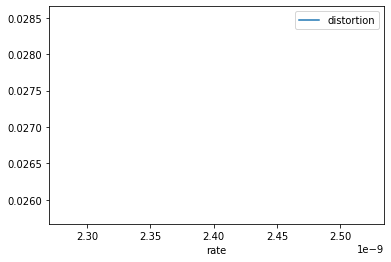

In [12]:
stochSys.cumsum()
stochSys.plot(x="rate", y='distortion')

### The Pareto Frontier
Now let's run the Information Bottleneck Method

In [13]:


# The structural phase transitions along the pareto frontier
stochSys = []
for i, q in enumerate(zip(qseq, qseqresults)):
    for w in mergecols(q[0]).transpose():
        stochSys.append([len(qseq)-i, q[1][0], q[1][1]] + list(w))

stochSys = pd.DataFrame(data=np.array(stochSys), columns = ['n', 'rate', 'distortion'] + items)


In [14]:
from scipy.spatial import distance

# compute distance from optimal frontier
def fd(asys, ibscores):
    mind = distance.cdist([[asys['rate'], asys['distortion']]], ibscores[['rate', 'distortion']]).min()
    return mind


def gNID_d(asys, paretoQs, betas, pX):
    mind = np.zeros((len(asys), len(paretoQs)))
    for li in range(len(asys)):
        for qi, q in enumerate(paretoQs):
            mind[li, qi] = gNID(asys.iloc[li]['q'], q, pX)
    return np.argmin(mind, axis=1), np.min(mind, axis=1), betas[np.argmin(mind, axis=1)]

